In [76]:
import get_stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [34]:
df = pd.read_csv("summary_stats.csv")
df.drop(columns=["Unnamed: 0", "Unnamed: 33_level_0", "Unnamed: 4_level_0"], inplace = True)
new_cols = ["Player", "Nation", "Pos", "Age", "MP", "Starts", "Minutes", "90s", "Gls", "Ast", "G+A", "G-PK", "PK", "PKatt", "CrdY", "CrdR", "xG", "npxG", "xAG", "npxG+xAG", "PrgC", "PrgP", "PrgR", "90_Gls", "90_Ast", "90_G+A", "90_G-PK", "90_G+A-PK", "90_xG", "90_xAG", "90_xG+xAG", "90_npxG", "90_npxG+xAG"]
mapping = dict(zip(df.columns, new_cols))
# print(dict(mapping))
df.rename(columns=mapping, inplace=True)

In [38]:
defenders = df[df["Pos"] == "DF"]
defenders.head()

,Player,Nation,Pos,Age,MP,Starts,Minutes,90s,Gls,Ast,...,90_Ast,90_G+A,90_G-PK,90_G+A-PK,90_xG,90_xAG,90_xG+xAG,90_npxG,90_npxG+xAG,Team
1,William Saliba,fr FRA,DF,22-213,9.0,9,810.0,9.0,0.0,1.0,...,0.11,0.11,0.0,0.11,0.0,0.01,0.01,0.0,0.01,arsenal
2,Ben White,eng ENG,DF,26-015,9.0,9,810.0,9.0,1.0,0.0,...,0.0,0.11,0.11,0.11,0.05,0.1,0.14,0.05,0.14,arsenal
7,Gabriel Dos Santos,br BRA,DF,25-308,8.0,6,566.0,6.3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.03,0.0,0.03,0.03,0.03,arsenal
9,Oleksandr Zinchenko,ua UKR,DF,26-312,8.0,6,468.0,5.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.05,0.06,0.12,0.05,0.12,arsenal
18,Takehiro Tomiyasu,jp JPN,DF,24-352,7.0,1,216.0,2.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.07,0.0,0.07,0.07,0.07,arsenal


# EDA Modelling Ideas

- Get actual player positions from the official fpl api. May require an intense mapping of player names if not set accordingly.
- Upload file of points rules so that we can calculate the per 90 expected points.
- Compare the per 90 expected points to actual points.

- For regression model we can look at correlations between form, xG points, xAG points, clean sheet points, minutes played

In [66]:
import requests
import json
response = requests.get("https://fantasy.premierleague.com/api/bootstrap-static/")
data = json.loads(response.text)

In [131]:
# Columns to keep for player stats
cols = ["code", "first_name", "second_name", "element_type", "web_name", "id", "team_code", "now_cost", "points_per_game", "selected_by_percent", "total_points", "transfers_in", "transfers_out", "minutes", "goals_scored", "assists", "clean_sheets", "goals_conceded", "own_goals", "penalties_saved", "penalties_missed", "yellow_cards", "red_cards", "saves", "bonus", "bps", "influence", "creativity", "threat", "ict_index", "starts", "expected_goals", "expected_assists", "expected_goal_involvements", "expected_goals_conceded", "expected_goals_per_90", "saves_per_90", "expected_assists_per_90", "expected_goal_involvements_per_90", "expected_goals_conceded_per_90"]

aggregated = pd.DataFrame()
for player in data["elements"]:
	df = pd.DataFrame.from_dict(player, orient="index")
	df = df.T[cols]
	aggregated = pd.concat([aggregated, df])
aggregated.set_index("id", inplace=True)
# Change expected goals to integers
aggregated["expected_goals"] = aggregated["expected_goals"].map(lambda x: float(x))


In [132]:
# Note that 1 = GK, 2 = DEF, 3 = MID, 4 = FWD
fwds = aggregated[aggregated["element_type"]==4]

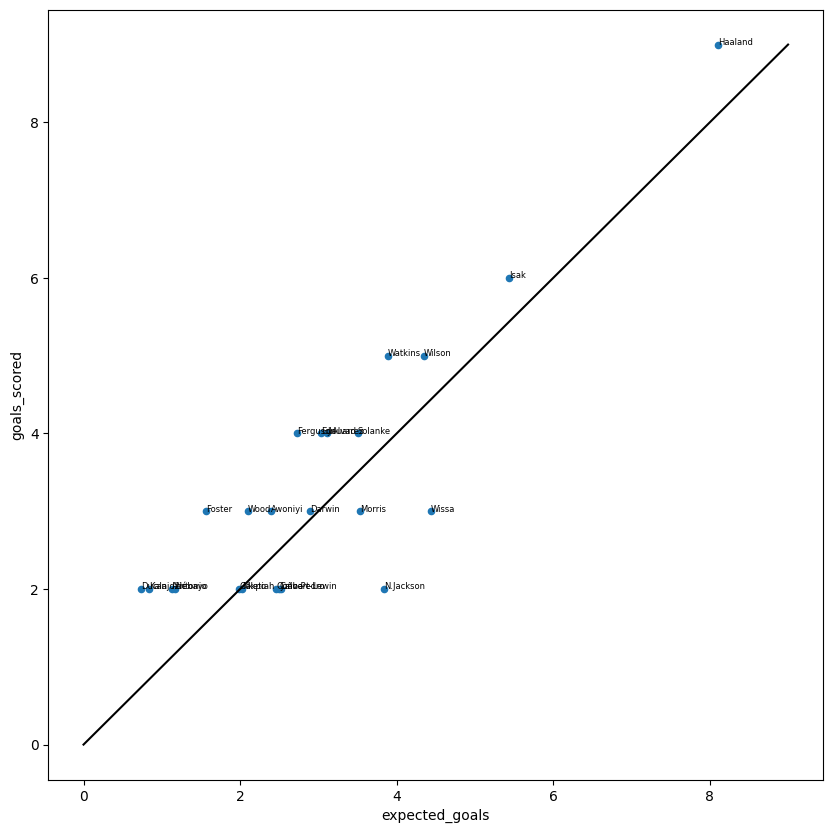

In [141]:
# Retain only players that have scored at least 2 goals
plt.figure(figsize=(10,10))
ax = plt.gca()
fwds = fwds[fwds["goals_scored"]>1]

# fwds["expected_goals"].values
# print(fwds["web_name"].values)
fwds.plot(kind="scatter", x="expected_goals", y="goals_scored", ax=ax)
x = fwds["expected_goals"].values; y = fwds["goals_scored"].values
txt = fwds["web_name"].values
for i in range(len(txt)):
	ax.annotate(txt[i], (x[i], y[i]), fontsize=6)
ax.plot(np.arange(10), np.arange(10), color="black")
